In [1]:
#13.2.1 오토인코더란

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="../chap13/data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting e:/torch/chap13/data\MNIST\raw\train-images-idx3-ubyte.gz to e:/torch/chap13/data\MNIST\raw


  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting e:/torch/chap13/data\MNIST\raw\train-labels-idx1-ubyte.gz to e:/torch/chap13/data\MNIST\raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting e:/torch/chap13/data\MNIST\raw\t10k-images-idx3-ubyte.gz to e:/torch/chap13/data\MNIST\raw


  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting e:/torch/chap13/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to e:/torch/chap13/data\MNIST\raw
Processing...


e:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
class Encoder(nn.Module):    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [5]:
encoder = Encoder(encoded_space_dim=4,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4,fc2_input_dim=128)
encoder.to(device)
decoder.to(device)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [6]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader: 
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [7]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): 
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [8]:
def add_noise(inputs,noise_factor=0.3):
    noisy = inputs+torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

In [9]:
from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

In [10]:
def plot_ae_outputs(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(3,n,i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img,noise_factor)     
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('원래 이미지')
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('노이즈가 적용되어 손상된 이미지')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('재구성된 이미지')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show() 

EPOCH 1/30

 EPOCH 1/30 	 train loss 0.089 	 val loss 0.050


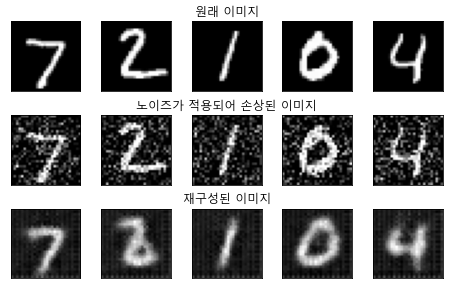

EPOCH 2/30

 EPOCH 2/30 	 train loss 0.055 	 val loss 0.043


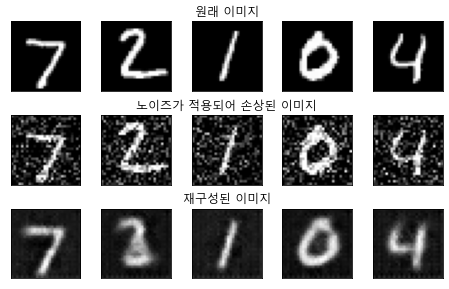

EPOCH 3/30

 EPOCH 3/30 	 train loss 0.053 	 val loss 0.042


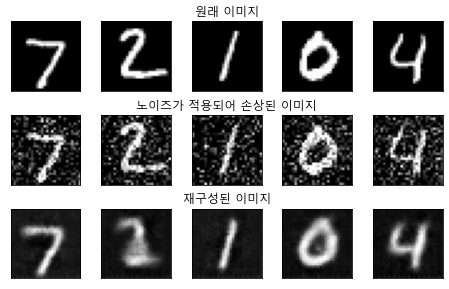

EPOCH 4/30

 EPOCH 4/30 	 train loss 0.052 	 val loss 0.041


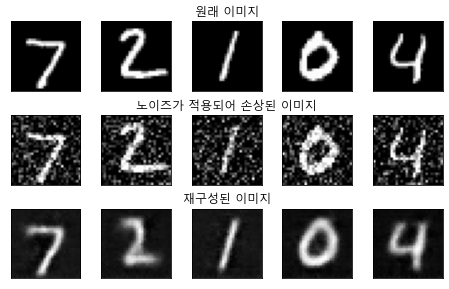

EPOCH 5/30

 EPOCH 5/30 	 train loss 0.052 	 val loss 0.041


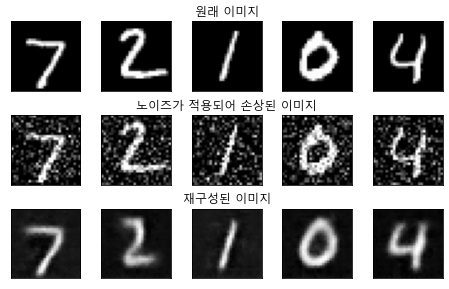

EPOCH 6/30

 EPOCH 6/30 	 train loss 0.051 	 val loss 0.041


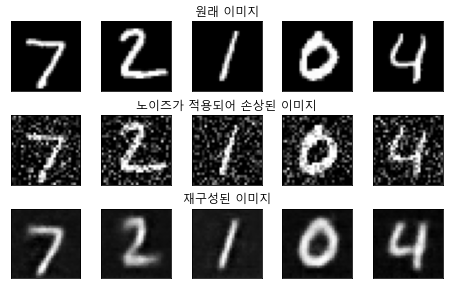

EPOCH 7/30

 EPOCH 7/30 	 train loss 0.051 	 val loss 0.040


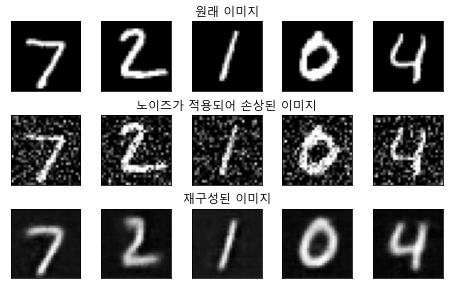

EPOCH 8/30

 EPOCH 8/30 	 train loss 0.051 	 val loss 0.040


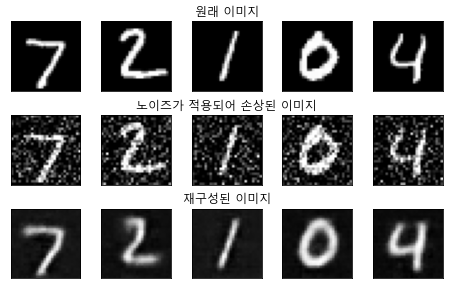

EPOCH 9/30

 EPOCH 9/30 	 train loss 0.051 	 val loss 0.039


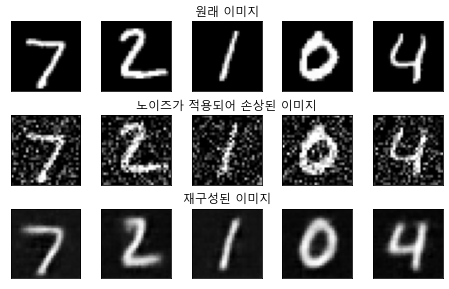

EPOCH 10/30

 EPOCH 10/30 	 train loss 0.050 	 val loss 0.040


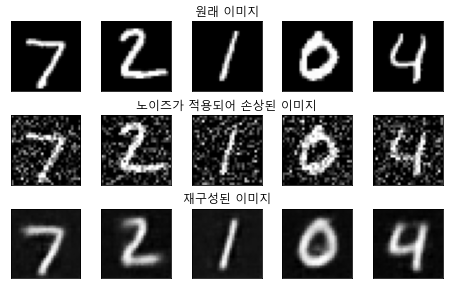

EPOCH 11/30

 EPOCH 11/30 	 train loss 0.050 	 val loss 0.039


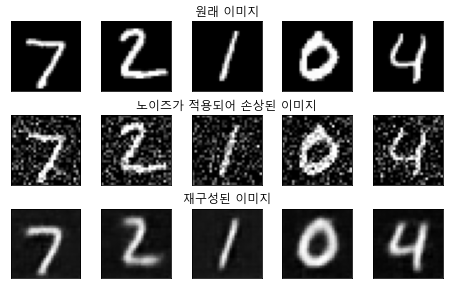

EPOCH 12/30

 EPOCH 12/30 	 train loss 0.050 	 val loss 0.039


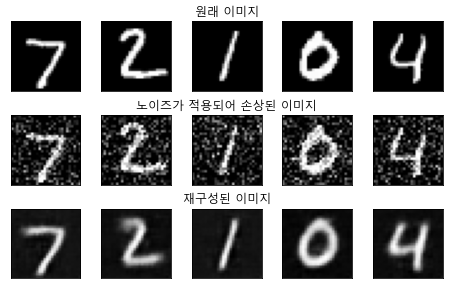

EPOCH 13/30

 EPOCH 13/30 	 train loss 0.050 	 val loss 0.039


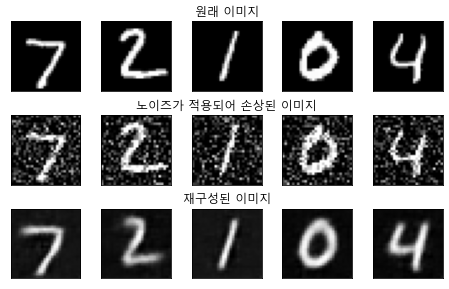

EPOCH 14/30

 EPOCH 14/30 	 train loss 0.050 	 val loss 0.039


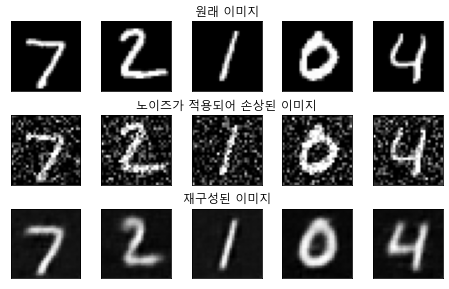

EPOCH 15/30

 EPOCH 15/30 	 train loss 0.050 	 val loss 0.039


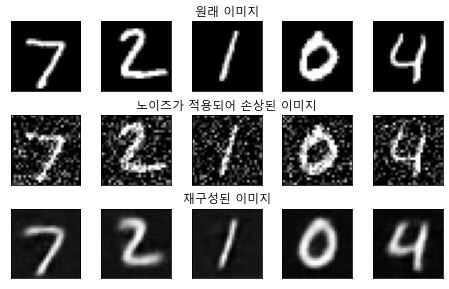

EPOCH 16/30

 EPOCH 16/30 	 train loss 0.050 	 val loss 0.039


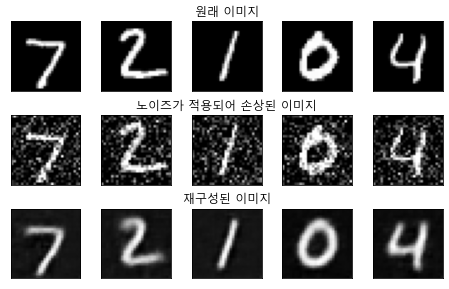

EPOCH 17/30

 EPOCH 17/30 	 train loss 0.050 	 val loss 0.039


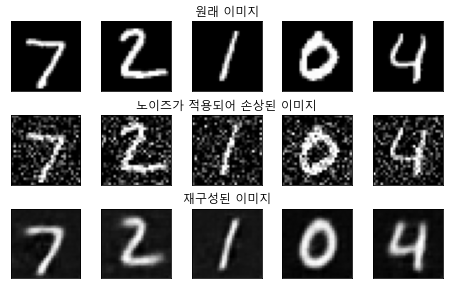

EPOCH 18/30

 EPOCH 18/30 	 train loss 0.050 	 val loss 0.038


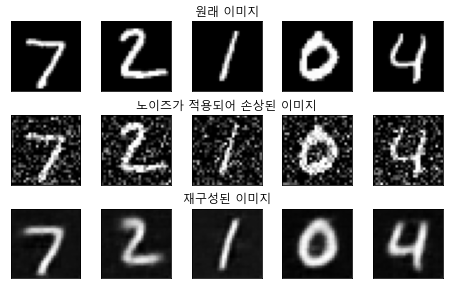

EPOCH 19/30

 EPOCH 19/30 	 train loss 0.050 	 val loss 0.038


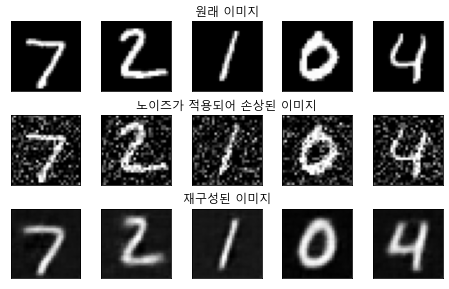

EPOCH 20/30

 EPOCH 20/30 	 train loss 0.050 	 val loss 0.038


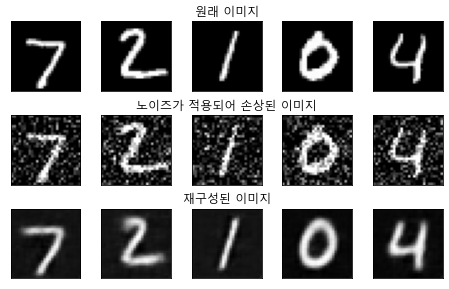

EPOCH 21/30

 EPOCH 21/30 	 train loss 0.050 	 val loss 0.038


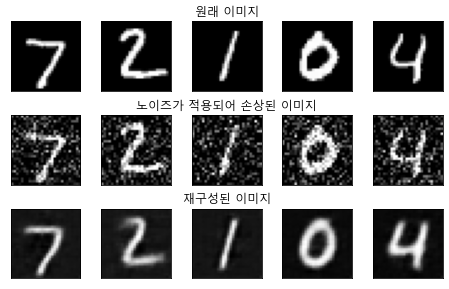

EPOCH 22/30

 EPOCH 22/30 	 train loss 0.050 	 val loss 0.038


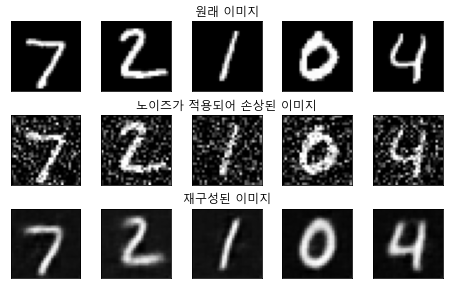

EPOCH 23/30

 EPOCH 23/30 	 train loss 0.049 	 val loss 0.038


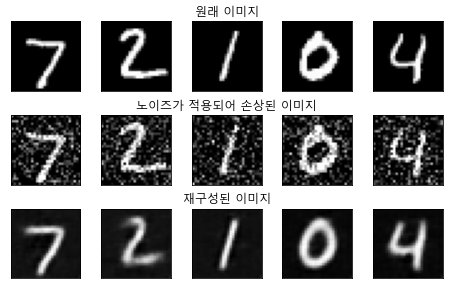

EPOCH 24/30

 EPOCH 24/30 	 train loss 0.049 	 val loss 0.038


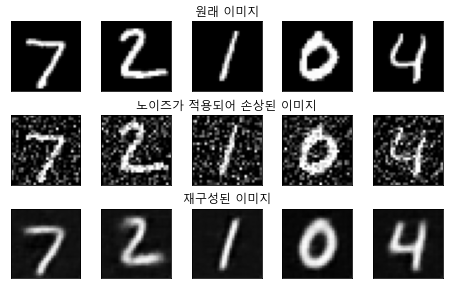

EPOCH 25/30

 EPOCH 25/30 	 train loss 0.049 	 val loss 0.038


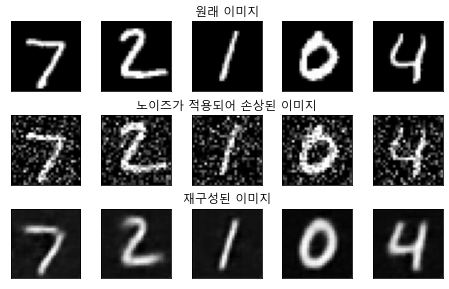

EPOCH 26/30

 EPOCH 26/30 	 train loss 0.049 	 val loss 0.038


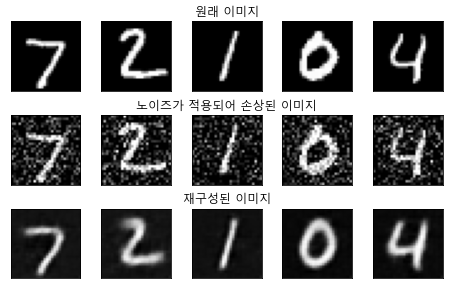

EPOCH 27/30

 EPOCH 27/30 	 train loss 0.049 	 val loss 0.038


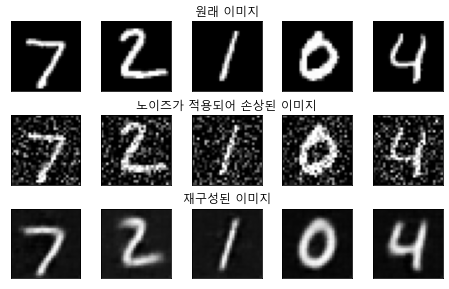

EPOCH 28/30

 EPOCH 28/30 	 train loss 0.049 	 val loss 0.037


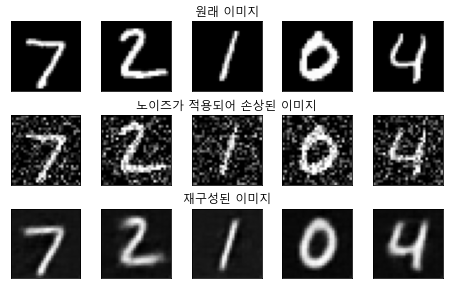

EPOCH 29/30

 EPOCH 29/30 	 train loss 0.049 	 val loss 0.038


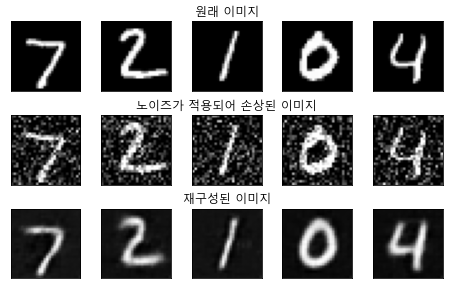

EPOCH 30/30

 EPOCH 30/30 	 train loss 0.049 	 val loss 0.037


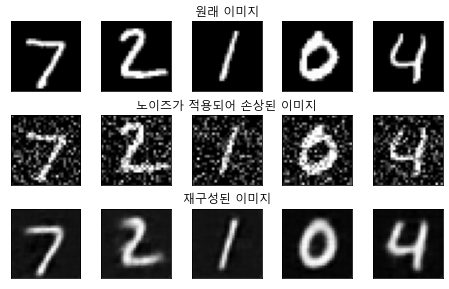

In [12]:
import numpy as np

num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    train_loss=train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim, noise_factor=0.3)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_loader, 
        loss_fn=loss_fn, noise_factor=0.3)
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(encoder,decoder,noise_factor=0.3)

In [1]:
#13.2.2 변형 오토인코더(Variational AutoEncoder)

In [2]:
import datetime
import os
from tensorboardX import SummaryWriter

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="../chap13/data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)

In [4]:
class Encoder(nn.Module):    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)        
        self.training = True
        
    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)                           
        return mean, log_var

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))        
        x_hat = torch.sigmoid(self.output(h))
        return x_hat

In [6]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)                
        z = mean + var*epsilon                          
        return z
                        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.Decoder(z)        
        return x_hat, mean, log_var

In [7]:
x_dim  = 784
hidden_dim = 400
latent_dim = 200
epochs = 30
batch_size = 100

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [8]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
saved_loc = 'scalar/'
writer = SummaryWriter(saved_loc)

model.train()
def train(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD
        writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(x)))
            
    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)))

In [10]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)        
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = BCE + KLD
        
            writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu()) 
                writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)

In [11]:
from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")
writer.close()

  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 544.363125
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 191.183652
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 188.099336
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 158.454238
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 155.638984
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 153.043203
======> Epoch: 0 Average loss: 173.2792


Train Epoch: 1 [0/60000 (0%)]	 Loss: 145.601250
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 134.434004
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 131.372871
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 132.994453
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 121.873936
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 121.991348
======> Epoch: 1 Average loss: 128.7373


Train Epoch: 2 [0/60000 (0%)]	 Loss: 123.755566
Train Epoch: 2 [10000/60000 (17%)]	 Loss: 118.792598
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 119.851875
Train Epoch: 2 [30000/60000 (50%)]	 Loss: 119.847559
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 112.737539
Train Epoch: 2 [50000/60000 (8

In [12]:
%load_ext tensorboard
%tensorboard --logdir scalar --port=6013

Reusing TensorBoard on port 6013 (pid 2584), started 0:16:58 ago. (Use '!kill 2584' to kill it.)

In [1]:
#13.3.2 GAN 구현하기

In [2]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 512
epochs = 200
sample_size = 64 
nz = 128 
k = 1 

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [7]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [8]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = [] 
losses_d = [] 
images = [] 

In [9]:
def save_generator_image(image, path):
    save_image(image, path)

In [10]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [11]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)    
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [12]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):                                
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, f"../chap13/img/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx 
    epoch_loss_d = loss_d / idx 
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 0 of 200
Generator loss: 1.28965569, Discriminator loss: 0.94043517


118it [00:48,  2.44it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 1 of 200
Generator loss: 2.55902362, Discriminator loss: 1.09625375


118it [00:48,  2.44it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 2 of 200
Generator loss: 6.74595404, Discriminator loss: 0.20054729


118it [00:48,  2.45it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 3 of 200
Generator loss: 1.58426058, Discriminator loss: 1.02565455


118it [00:48,  2.45it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 4 of 200
Generator loss: 2.40962863, Discriminator loss: 1.11043680


118it [00:48,  2.45it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 5 of 200
Generator loss: 4.19420624, Discriminator loss: 0.73168665


118it [00:48,  2.45it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 6 of 200
Generator loss: 1.07368362, Discriminator loss: 1.36239409


118it [00:48,  2.44it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 7 of 200
Generator loss: 1.20798695, Discriminator loss: 0.96279657


118it [00:48,  2.45it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 8 of 200
Generator loss: 1.98754001, Discriminator loss: 0.80611831


118it [00:47,  2.46it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 9 of 200
Generator loss: 2.32187963, Discriminator loss: 0.81639731


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 10 of 200
Generator loss: 2.78146076, Discriminator loss: 0.72524267


118it [00:55,  2.13it/s]                                                                                               


Epoch 11 of 200
Generator loss: 2.75920534, Discriminator loss: 0.76865184


118it [00:48,  2.42it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 12 of 200
Generator loss: 3.37288237, Discriminator loss: 0.79356098


118it [00:50,  2.32it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 13 of 200
Generator loss: 2.76482487, Discriminator loss: 0.77461821


118it [00:50,  2.35it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 14 of 200
Generator loss: 3.32652903, Discriminator loss: 0.51153821


118it [00:50,  2.32it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 15 of 200
Generator loss: 3.28289485, Discriminator loss: 0.49147308


118it [00:51,  2.27it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 16 of 200
Generator loss: 3.25030255, Discriminator loss: 0.49205813


118it [00:50,  2.32it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 17 of 200
Generator loss: 2.71232343, Discriminator loss: 0.57658309


118it [00:54,  2.17it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 18 of 200
Generator loss: 2.44893456, Discriminator loss: 0.69853437


118it [00:54,  2.16it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 19 of 200
Generator loss: 2.00435877, Discriminator loss: 0.76643795


118it [00:51,  2.28it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 20 of 200
Generator loss: 2.64299703, Discriminator loss: 0.60295892


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 21 of 200
Generator loss: 2.74489236, Discriminator loss: 0.59196866


118it [00:49,  2.40it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 22 of 200
Generator loss: 2.35208440, Discriminator loss: 0.62202233


118it [00:48,  2.41it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 23 of 200
Generator loss: 3.12820005, Discriminator loss: 0.52957422


118it [00:48,  2.42it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 24 of 200
Generator loss: 3.08820009, Discriminator loss: 0.48764977


118it [00:48,  2.42it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 25 of 200
Generator loss: 3.30924797, Discriminator loss: 0.40163657


118it [00:49,  2.40it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 26 of 200
Generator loss: 3.20945001, Discriminator loss: 0.57617122


118it [00:48,  2.42it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 27 of 200
Generator loss: 2.68442106, Discriminator loss: 0.51311344


118it [00:48,  2.44it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 28 of 200
Generator loss: 2.87483597, Discriminator loss: 0.51513243


118it [00:48,  2.41it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 29 of 200
Generator loss: 2.59828401, Discriminator loss: 0.62996304


118it [00:48,  2.42it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 30 of 200
Generator loss: 2.81499219, Discriminator loss: 0.55426395


118it [00:48,  2.42it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 31 of 200
Generator loss: 2.95094156, Discriminator loss: 0.42584577


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 32 of 200
Generator loss: 3.54328036, Discriminator loss: 0.42313153


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 33 of 200
Generator loss: 3.52649713, Discriminator loss: 0.43269742


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 34 of 200
Generator loss: 3.38772774, Discriminator loss: 0.51199806


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 35 of 200
Generator loss: 2.84410238, Discriminator loss: 0.53923756


118it [00:49,  2.38it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 36 of 200
Generator loss: 3.58646393, Discriminator loss: 0.34592268


118it [00:49,  2.38it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 37 of 200
Generator loss: 3.63640261, Discriminator loss: 0.43147662


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 38 of 200
Generator loss: 3.04674387, Discriminator loss: 0.43668997


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 39 of 200
Generator loss: 3.31387782, Discriminator loss: 0.38711658


118it [00:49,  2.38it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 40 of 200
Generator loss: 3.67020679, Discriminator loss: 0.37179121


118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 41 of 200
Generator loss: 3.72627282, Discriminator loss: 0.40914419


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 42 of 200
Generator loss: 3.59147072, Discriminator loss: 0.37340650


118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 43 of 200
Generator loss: 3.33224845, Discriminator loss: 0.41290221


118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 44 of 200
Generator loss: 3.44683003, Discriminator loss: 0.37105030


118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 45 of 200
Generator loss: 3.56013107, Discriminator loss: 0.35490730


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 46 of 200
Generator loss: 3.48438644, Discriminator loss: 0.41087869


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 47 of 200
Generator loss: 3.50132418, Discriminator loss: 0.39600083


118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 48 of 200
Generator loss: 3.34003901, Discriminator loss: 0.39516306


118it [00:49,  2.38it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 49 of 200
Generator loss: 3.42151451, Discriminator loss: 0.40769339


118it [00:49,  2.39it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 50 of 200
Generator loss: 3.49832106, Discriminator loss: 0.42497492


118it [00:50,  2.35it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 51 of 200
Generator loss: 3.35009003, Discriminator loss: 0.41334188


118it [00:49,  2.40it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 52 of 200
Generator loss: 3.26626873, Discriminator loss: 0.43543357


118it [00:49,  2.38it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 53 of 200
Generator loss: 3.43702888, Discriminator loss: 0.44312117


118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 54 of 200
Generator loss: 3.31210828, Discriminator loss: 0.45836058


118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 55 of 200
Generator loss: 3.12455964, Discriminator loss: 0.41909766


118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 56 of 200
Generator loss: 3.07070947, Discriminator loss: 0.44775221


118it [00:50,  2.32it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 57 of 200
Generator loss: 2.99900937, Discriminator loss: 0.46357921


118it [00:49,  2.38it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 58 of 200
Generator loss: 2.98589325, Discriminator loss: 0.51867241


118it [00:49,  2.38it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 59 of 200
Generator loss: 2.81873965, Discriminator loss: 0.55193484


118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 60 of 200
Generator loss: 2.94909453, Discriminator loss: 0.48560792


118it [00:50,  2.35it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 61 of 200
Generator loss: 2.94729066, Discriminator loss: 0.51357120


118it [00:50,  2.36it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 62 of 200
Generator loss: 2.98784256, Discriminator loss: 0.49404398


118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 63 of 200
Generator loss: 2.81716681, Discriminator loss: 0.51388294


118it [00:49,  2.36it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 64 of 200
Generator loss: 2.95755959, Discriminator loss: 0.47684026


118it [00:49,  2.36it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 65 of 200
Generator loss: 2.86248350, Discriminator loss: 0.48882347


118it [00:49,  2.36it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 66 of 200
Generator loss: 2.64461851, Discriminator loss: 0.52862209


118it [00:50,  2.35it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 67 of 200
Generator loss: 2.73632932, Discriminator loss: 0.50190759


118it [00:49,  2.37it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 68 of 200
Generator loss: 2.71615386, Discriminator loss: 0.50233990


118it [00:50,  2.35it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 69 of 200
Generator loss: 2.66935420, Discriminator loss: 0.53744847


118it [00:50,  2.32it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 70 of 200
Generator loss: 2.64303017, Discriminator loss: 0.53237331


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 71 of 200
Generator loss: 2.56712198, Discriminator loss: 0.56830966


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 72 of 200
Generator loss: 2.62840772, Discriminator loss: 0.56560397


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 73 of 200
Generator loss: 2.54245114, Discriminator loss: 0.61342889


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 74 of 200
Generator loss: 2.46235800, Discriminator loss: 0.60648018


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 75 of 200
Generator loss: 2.30789924, Discriminator loss: 0.65843248


118it [00:46,  2.53it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 76 of 200
Generator loss: 2.32383943, Discriminator loss: 0.62310845


118it [00:46,  2.53it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 77 of 200
Generator loss: 2.40012670, Discriminator loss: 0.61518693


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 78 of 200
Generator loss: 2.54398870, Discriminator loss: 0.60673636


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 79 of 200
Generator loss: 2.39061093, Discriminator loss: 0.64438021


118it [00:45,  2.57it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 80 of 200
Generator loss: 2.38155270, Discriminator loss: 0.64626241


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 81 of 200
Generator loss: 2.38102746, Discriminator loss: 0.65053701


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 82 of 200
Generator loss: 2.36338711, Discriminator loss: 0.65195107


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 83 of 200
Generator loss: 2.32608318, Discriminator loss: 0.66089076


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 84 of 200
Generator loss: 2.24759650, Discriminator loss: 0.70122755


118it [00:46,  2.57it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 85 of 200
Generator loss: 2.18878174, Discriminator loss: 0.71153152


118it [00:45,  2.58it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 86 of 200
Generator loss: 2.08417916, Discriminator loss: 0.73585075


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 87 of 200
Generator loss: 2.17768741, Discriminator loss: 0.72119433


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 88 of 200
Generator loss: 2.12150931, Discriminator loss: 0.72976667


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 89 of 200
Generator loss: 2.05236220, Discriminator loss: 0.75012696


118it [00:45,  2.57it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 90 of 200
Generator loss: 2.04905891, Discriminator loss: 0.75514430


118it [00:46,  2.52it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 91 of 200
Generator loss: 2.04667163, Discriminator loss: 0.76061523


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 92 of 200
Generator loss: 2.09347057, Discriminator loss: 0.75859982


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 93 of 200
Generator loss: 2.02316523, Discriminator loss: 0.75321144


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 94 of 200
Generator loss: 2.01148915, Discriminator loss: 0.76207858


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 95 of 200
Generator loss: 1.99193549, Discriminator loss: 0.77953190


118it [00:45,  2.57it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 96 of 200
Generator loss: 1.95865226, Discriminator loss: 0.79078877


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 97 of 200
Generator loss: 1.89810014, Discriminator loss: 0.80671018


118it [00:45,  2.57it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 98 of 200
Generator loss: 1.87897360, Discriminator loss: 0.79006290


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 99 of 200
Generator loss: 1.90792060, Discriminator loss: 0.80048490


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 100 of 200
Generator loss: 1.93200541, Discriminator loss: 0.80360395


118it [00:46,  2.53it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 101 of 200
Generator loss: 1.90037155, Discriminator loss: 0.81131756


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 102 of 200
Generator loss: 1.91203415, Discriminator loss: 0.79768729


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 103 of 200
Generator loss: 1.87438297, Discriminator loss: 0.82516950


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 104 of 200
Generator loss: 1.85394716, Discriminator loss: 0.82184088


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 105 of 200
Generator loss: 1.84038627, Discriminator loss: 0.83849722


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 106 of 200
Generator loss: 1.86461508, Discriminator loss: 0.81787968


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 107 of 200
Generator loss: 1.81579566, Discriminator loss: 0.83122605


118it [00:46,  2.52it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 108 of 200
Generator loss: 1.78685057, Discriminator loss: 0.83739710


118it [00:47,  2.47it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 109 of 200
Generator loss: 1.80268228, Discriminator loss: 0.85472798


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 110 of 200
Generator loss: 1.83276463, Discriminator loss: 0.84663105


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 111 of 200
Generator loss: 1.87620032, Discriminator loss: 0.82144499


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 112 of 200
Generator loss: 1.85461533, Discriminator loss: 0.83060545


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 113 of 200
Generator loss: 1.82103527, Discriminator loss: 0.82953876


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 114 of 200
Generator loss: 1.80623150, Discriminator loss: 0.82402432


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 115 of 200
Generator loss: 1.89462125, Discriminator loss: 0.82328910


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 116 of 200
Generator loss: 1.78881836, Discriminator loss: 0.85736054


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 117 of 200
Generator loss: 1.78126156, Discriminator loss: 0.86866146


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 118 of 200
Generator loss: 1.79257190, Discriminator loss: 0.86331391


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 119 of 200
Generator loss: 1.77693009, Discriminator loss: 0.86713052


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 120 of 200
Generator loss: 1.79919624, Discriminator loss: 0.83888078


118it [00:46,  2.52it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 121 of 200
Generator loss: 1.78879833, Discriminator loss: 0.87638384


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 122 of 200
Generator loss: 1.80974483, Discriminator loss: 0.87724090


118it [00:45,  2.57it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 123 of 200
Generator loss: 1.72000790, Discriminator loss: 0.88415706


118it [00:45,  2.58it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 124 of 200
Generator loss: 1.63302362, Discriminator loss: 0.91532344


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 125 of 200
Generator loss: 1.62798345, Discriminator loss: 0.90293980


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 126 of 200
Generator loss: 1.62705028, Discriminator loss: 0.90938658


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 127 of 200
Generator loss: 1.60531592, Discriminator loss: 0.94403166


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 128 of 200
Generator loss: 1.65054631, Discriminator loss: 0.91510224


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 129 of 200
Generator loss: 1.60562193, Discriminator loss: 0.91897315


118it [00:46,  2.53it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 130 of 200
Generator loss: 1.56841290, Discriminator loss: 0.94110203


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 131 of 200
Generator loss: 1.58421731, Discriminator loss: 0.93896371


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 132 of 200
Generator loss: 1.61653090, Discriminator loss: 0.91862214


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 133 of 200
Generator loss: 1.60154033, Discriminator loss: 0.91586053


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 134 of 200
Generator loss: 1.58900476, Discriminator loss: 0.94457316


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 135 of 200
Generator loss: 1.56310189, Discriminator loss: 0.94206369


118it [00:46,  2.53it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 136 of 200
Generator loss: 1.56481695, Discriminator loss: 0.95387912


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 137 of 200
Generator loss: 1.53593040, Discriminator loss: 0.96277684


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 138 of 200
Generator loss: 1.56144392, Discriminator loss: 0.94876188


118it [00:46,  2.53it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 139 of 200
Generator loss: 1.55007088, Discriminator loss: 0.95051944


118it [00:46,  2.52it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 140 of 200
Generator loss: 1.58603764, Discriminator loss: 0.93917716


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 141 of 200
Generator loss: 1.52282572, Discriminator loss: 0.96398252


118it [00:46,  2.56it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 142 of 200
Generator loss: 1.50992072, Discriminator loss: 0.97313142


118it [00:47,  2.50it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 143 of 200
Generator loss: 1.50291181, Discriminator loss: 0.97744519


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 144 of 200
Generator loss: 1.52830935, Discriminator loss: 0.96633893


118it [00:47,  2.51it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 145 of 200
Generator loss: 1.51088667, Discriminator loss: 0.97132522


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 146 of 200
Generator loss: 1.50719988, Discriminator loss: 0.95362425


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 147 of 200
Generator loss: 1.54594529, Discriminator loss: 0.96649355


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 148 of 200
Generator loss: 1.42658901, Discriminator loss: 0.99921048


118it [00:46,  2.52it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 149 of 200
Generator loss: 1.44845259, Discriminator loss: 0.99404848


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 150 of 200
Generator loss: 1.46749294, Discriminator loss: 0.98143983


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 151 of 200
Generator loss: 1.46907854, Discriminator loss: 0.98531985


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 152 of 200
Generator loss: 1.44619024, Discriminator loss: 0.99880630


118it [00:46,  2.52it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 153 of 200
Generator loss: 1.40995061, Discriminator loss: 1.01468205


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 154 of 200
Generator loss: 1.44595623, Discriminator loss: 1.01123023


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 155 of 200
Generator loss: 1.37167144, Discriminator loss: 1.00867724


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 156 of 200
Generator loss: 1.37236857, Discriminator loss: 1.02114487


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 157 of 200
Generator loss: 1.38655329, Discriminator loss: 1.03353417


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 158 of 200
Generator loss: 1.35241055, Discriminator loss: 1.03571653


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 159 of 200
Generator loss: 1.38465858, Discriminator loss: 1.03841317


118it [00:46,  2.53it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 160 of 200
Generator loss: 1.39623487, Discriminator loss: 1.03911889


118it [00:45,  2.57it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 161 of 200
Generator loss: 1.35889268, Discriminator loss: 1.03902733


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 162 of 200
Generator loss: 1.39510179, Discriminator loss: 1.02421236


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 163 of 200
Generator loss: 1.37813866, Discriminator loss: 1.02041662


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 164 of 200
Generator loss: 1.33441377, Discriminator loss: 1.04793561


118it [00:46,  2.54it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 165 of 200
Generator loss: 1.33716297, Discriminator loss: 1.06110775


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 166 of 200
Generator loss: 1.39043736, Discriminator loss: 1.02346504


118it [00:46,  2.51it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 167 of 200
Generator loss: 1.34985602, Discriminator loss: 1.05041564


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 168 of 200
Generator loss: 1.36765397, Discriminator loss: 1.04588032


118it [00:46,  2.55it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 169 of 200
Generator loss: 1.34903169, Discriminator loss: 1.03718805


118it [00:48,  2.45it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 170 of 200
Generator loss: 1.31560922, Discriminator loss: 1.06189883


118it [00:50,  2.34it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 171 of 200
Generator loss: 1.40137887, Discriminator loss: 1.02350354


118it [00:50,  2.32it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 172 of 200
Generator loss: 1.34082305, Discriminator loss: 1.06064725


118it [00:50,  2.34it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 173 of 200
Generator loss: 1.32035995, Discriminator loss: 1.06106329


118it [00:50,  2.34it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 174 of 200
Generator loss: 1.28886724, Discriminator loss: 1.06986165


118it [00:50,  2.33it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 175 of 200
Generator loss: 1.34153867, Discriminator loss: 1.04400194


118it [00:50,  2.32it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 176 of 200
Generator loss: 1.32281721, Discriminator loss: 1.05535209


118it [00:50,  2.32it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 177 of 200
Generator loss: 1.31100547, Discriminator loss: 1.05821729


118it [00:50,  2.33it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 178 of 200
Generator loss: 1.30001235, Discriminator loss: 1.06758904


118it [00:54,  2.18it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 179 of 200
Generator loss: 1.28286922, Discriminator loss: 1.07115126


118it [01:04,  1.83it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 180 of 200
Generator loss: 1.31736088, Discriminator loss: 1.06526792


118it [00:58,  2.01it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 181 of 200
Generator loss: 1.35032368, Discriminator loss: 1.07523263


118it [00:54,  2.17it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 182 of 200
Generator loss: 1.26838982, Discriminator loss: 1.08266544


118it [00:54,  2.15it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 183 of 200
Generator loss: 1.23457587, Discriminator loss: 1.09275341


118it [00:53,  2.23it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 184 of 200
Generator loss: 1.28434587, Discriminator loss: 1.07587135


118it [00:53,  2.22it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 185 of 200
Generator loss: 1.29155636, Discriminator loss: 1.08100331


118it [00:50,  2.33it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 186 of 200
Generator loss: 1.26317942, Discriminator loss: 1.07565284


118it [00:51,  2.30it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 187 of 200
Generator loss: 1.32459807, Discriminator loss: 1.06631184


118it [00:54,  2.16it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 188 of 200
Generator loss: 1.28856599, Discriminator loss: 1.07111943


118it [00:52,  2.24it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 189 of 200
Generator loss: 1.27965236, Discriminator loss: 1.06941783


118it [00:56,  2.08it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 190 of 200
Generator loss: 1.25732982, Discriminator loss: 1.09096444


118it [00:51,  2.30it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 191 of 200
Generator loss: 1.27831495, Discriminator loss: 1.09031868


118it [00:50,  2.32it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 192 of 200
Generator loss: 1.28132653, Discriminator loss: 1.08272088


118it [00:51,  2.30it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 193 of 200
Generator loss: 1.26212227, Discriminator loss: 1.09438193


118it [00:50,  2.35it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 194 of 200
Generator loss: 1.26986551, Discriminator loss: 1.09756744


118it [00:51,  2.29it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 195 of 200
Generator loss: 1.28353238, Discriminator loss: 1.06755567


118it [00:56,  2.09it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 196 of 200
Generator loss: 1.26950192, Discriminator loss: 1.08437514


118it [00:52,  2.24it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 197 of 200
Generator loss: 1.23257947, Discriminator loss: 1.10518491


118it [00:53,  2.22it/s]                                                                                               
  0%|                                                                                          | 0/117 [00:00<?, ?it/s]

Epoch 198 of 200
Generator loss: 1.28899515, Discriminator loss: 1.08550680


118it [00:51,  2.28it/s]                                                                                               

Epoch 199 of 200
Generator loss: 1.31970513, Discriminator loss: 1.07432187


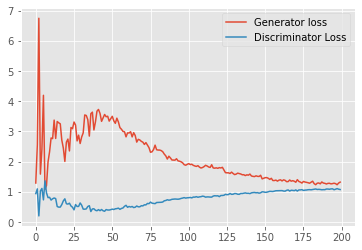

In [13]:
plt.figure()
losses_g = [fl.item() for fl in losses_g ]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d ]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()

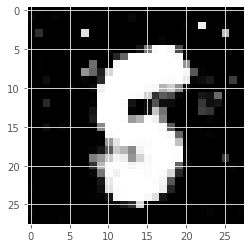

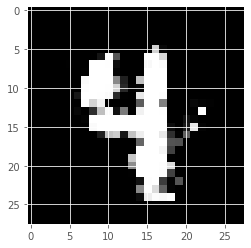

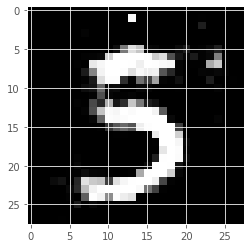

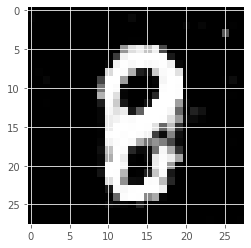

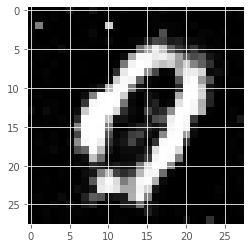

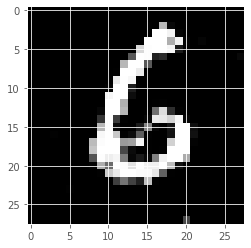

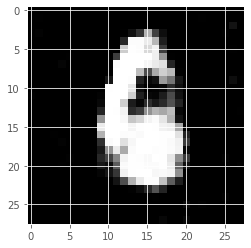

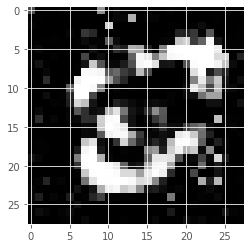

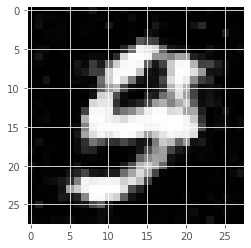

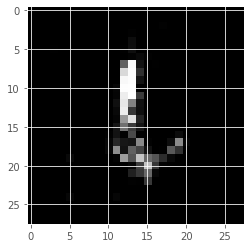

In [14]:
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')    
    plt.show()